In [5]:
! which python

/usr/local/anaconda3/envs/reproducibleML/bin/python


In [6]:
import torch, torchaudio
import pytorch_lightning as pl
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

In [48]:
from torch import nn
from torch.nn import functional as F

In [4]:
print(torch.__version__)

1.8.0


In [7]:
print(torch.cuda.is_available())

False


In [14]:
datapath = Path('../data/ESC-50-master')

In [15]:
datapath.exists()

True

In [16]:
csv = pd.read_csv(datapath / 'meta/esc50.csv')

torch.Size([1, 220500])


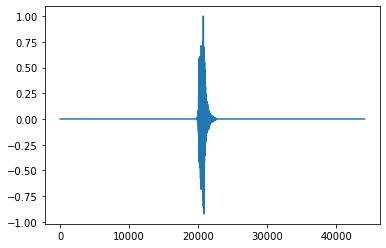

In [17]:

x, sr = torchaudio.load(datapath / 'audio' / csv.iloc[0, 0], normalize=True)
print(x.shape)
plt.plot(x[0, ::5])
plt.show()

torch.Size([1, 128, 1103])


/usr/local/anaconda3/envs/reproducibleML/lib/python3.7/site-packages/torchaudio/functional/functional.py:358: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


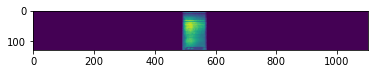

In [18]:
torchaudio.transforms.Resample(orig_freq=sr, new_freq=8000)(x).shape

h = torchaudio.transforms.MelSpectrogram(sample_rate=sr)(x)
print(h.shape)
h = torchaudio.transforms.AmplitudeToDB()(h)
plt.imshow(h[0])
plt.show()

In [39]:
class ESC50Dataset(torch.utils.data.Dataset):

    def __init__(self, path: Path = Path('../data/ESC-50-master'), sample_rate: int = 8000, folds = [1]):
        # Load CSV & initialize all torchaudio.transforms
        # Resample --> MelSpectrogram --> AmplitudeToDB
        self.path = path
        self.csv = pd.read_csv(path / Path('meta/esc50.csv'))
        self.csv = self.csv[self.csv['fold'].isin(folds)]

        self.resample = torchaudio.transforms.Resample(orig_freq=44100, new_freq=sample_rate)
        self.melspec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate)
        self.db = torchaudio.transforms.AmplitudeToDB()

    def __getitem__(self, index):
        # Returns (xb, yb) pair
        row = self.csv.iloc[index]
        wav, _ = torchaudio.load(self.path / 'audio' / row['filename'])
        label = row['target']
        xb = self.db(self.melspec(self.resample(wav)))
        return xb, label


    def __len__(self):
        # Returns length
        return len(self.csv)


In [43]:
train_data = ESC50Dataset(folds=[1])
val_data = ESC50Dataset(folds=[2])
test_data = ESC50Dataset(folds=[3])

In [41]:
for xb, yb in train_data:
    break

In [44]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)

In [46]:
val_loader = torch.utils.data.DataLoader(val_data, batch_size=8)

In [45]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=8)

## Build the model

In [47]:
class AudioNet(torch.nn.Module):
 
    def __init__(self, n_classes = 50, base_filters = 64):
        super().__init__()
        self.conv1 = nn.Conv2d(1, base_filters, 11, padding=5)
        self.bn1 = nn.BatchNorm2d(base_filters)
        self.conv2 = nn.Conv2d(base_filters, base_filters, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(base_filters)
        self.pool1 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(base_filters, base_filters * 2, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(base_filters * 2)
        self.conv4 = nn.Conv2d(base_filters * 2, base_filters * 4, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(base_filters * 4)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(base_filters * 4, n_classes)
 
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool1(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool2(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = self.fc1(x[:, :, 0, 0])
        return x

In [55]:
class LitAutoEncoder(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 64),
            nn.ReLU(),
            nn.Linear(64, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 28*28)
        )

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        embedding = self.encoder(x)
        return embedding

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, y = batch
        y_hat = self.x
        x_hat = self.decoder(z)
        loss = F.crossentropy(y_hat, y)
        # Logging to TensorBoard by default
        self.log('train_loss', loss, on_step=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat = torch.argmax(y_hat, dim=1)
        acc = pl.metrics.functional.accuracy(y_hat, y)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)
        return acc
        
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [56]:
pl.seed_everything(0)

Global seed set to 0


0

In [57]:
trainer = pl.Trainer(max_epochs=1) # fsst_dev_run=True to train very fast

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [50]:
audionet = AudioNet(base_filters=32)

In [52]:
xb, yb = next(iter(train_loader))

In [53]:
xb.shape

torch.Size([8, 1, 128, 201])

In [54]:
audionet(xb).shape

torch.Size([8, 50])

In [58]:
trainer.fit(audionet, train_loader, val_loader)

AttributeError: 'AudioNet' object has no attribute 'automatic_optimization'

In [59]:
trainer.test(audionet, test_loader)

AttributeError: 'AudioNet' object has no attribute 'automatic_optimization'